In [9]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
import keras.backend as K
from keras.layers import Lambda

import tensorflow as tf

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

from aparent.data.aparent_data_plasmid_legacy import load_data

from analyze_aparent_conv_layers_helpers import *


In [2]:
#Load random MPRA data

file_path = '../data/random_mpra_legacy/combined_library/processed_data_lifted/'
plasmid_gens = load_data(batch_size=32, valid_set_size=1000, test_set_size=120000, kept_libraries=[22], canonical_pas=True, file_path=file_path)


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Training set size = 203504
Validation set size = 1000
Test set size = 120000


In [3]:
#Re-shuffle test set index

plasmid_index = np.arange(len(plasmid_gens['all'].sources['df']), dtype=np.int)
np.random.shuffle(plasmid_index)

plasmid_gens['test'].data_ids = plasmid_index[:120000]


In [4]:
#Load legacy APARENT model (lifted from theano)

model_name = 'aparent_theano_legacy_30_31_34'#_pasaligned

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
#Retrieve one-hot input sequences
onehot_seqs = np.concatenate([plasmid_gens['test'][i][0][0][:, 0, :, :] for i in range(len(plasmid_gens['test']))], axis=0)


In [6]:
#Slice out only the interesting sequence region (DSE)
onehot_seqs = onehot_seqs[:, 55: 100 - 8 + 8, :]


In [7]:
#Create a new model that outputs the conv layer activation maps together with the isoform proportion
cut_model = Model(
    inputs = aparent_model.inputs,
    outputs = [
        aparent_model.get_layer('cut_out_layer_1').output
    ]
)

#Predict from test data generator
cut_pred = cut_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)

cut_logodds = np.log(cut_pred / (1. - cut_pred))

cut_pred = cut_pred[:, 55: 100]
cut_logodds = cut_logodds[:, 55: 100]

In [ ]:
#Layer 1: Compute Max Activation Correlation maps and PWMs
filter_width = 8
n_samples = 1500
n_filters = 70

pwms = np.zeros((n_filters, filter_width, 4))
pwms_top = np.zeros((n_filters, filter_width, 4))

r_vals = np.zeros((n_filters, 100 - 55 - 8, cut_pred.shape[1]))

filter_batch_size = 10
cut_conv_1_out_cache = None

for k in range(n_filters) :
    #Create a new model that outputs the conv layer activation maps
    
    #Compute and cache batch of filters
    if k % filter_batch_size == 0 :
        filter_batch_start = k
        filter_batch_end = k + filter_batch_size #Exclusive index
    
        def slice_func(x) :
            return x[:, filter_batch_start: filter_batch_end, 55: 100 - 8, 0]

        sliced_conv_out = Lambda(lambda x: slice_func(x), output_shape=(filter_batch_size, 100 - 55 - 8,))(
            aparent_model.get_layer('cut_conv_layer_1').output
        )

        conv_layer_cut_model = Model(
            inputs = aparent_model.inputs,
            outputs = [
                sliced_conv_out
            ]
        )

        #Predict from test data generator
        cut_conv_1_out_cache = conv_layer_cut_model.predict_generator(plasmid_gens['test'], workers=4, use_multiprocessing=True)
    
    cut_conv_1_out = cut_conv_1_out_cache[:, int(k % filter_batch_size), :]

    
    for i in range(cut_conv_1_out.shape[0]) :
        max_j = np.argmax(cut_conv_1_out[i, :])
        if cut_conv_1_out[i, max_j] > 0 :
            pwms[k, :, :] += onehot_seqs[i, max_j: max_j+filter_width, :]
    
    sort_index = np.argsort(np.max(cut_conv_1_out, axis=-1))[::-1]
    for i in range(n_samples) :
        max_j = np.argmax(cut_conv_1_out[sort_index[i], :])
        if cut_conv_1_out[sort_index[i], max_j] > 0 :
            pwms_top[k, :, :] += onehot_seqs[sort_index[i], max_j: max_j+filter_width, :]
    
    
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

    #Compute correlation map for filter k
    for j in range(cut_conv_1_out.shape[1]) :
        for v in range(cut_pred.shape[1]) :
            if np.any(cut_conv_1_out[:, j] > 0.) :
                r_val, _ = pearsonr(cut_conv_1_out[:, j], cut_logodds[:, v])
                #r_val, _ = pearsonr(cut_conv_1_out[:, j], cut_pred[:, v])
                r_vals[k, j, v] = r_val if not np.isnan(r_val) else 0


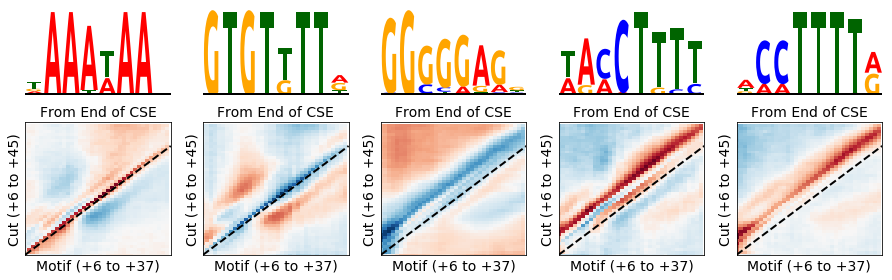

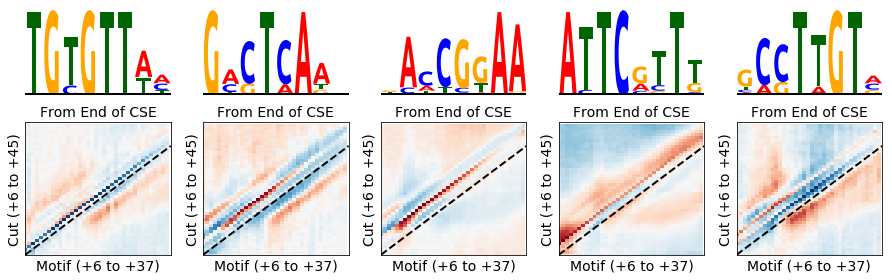

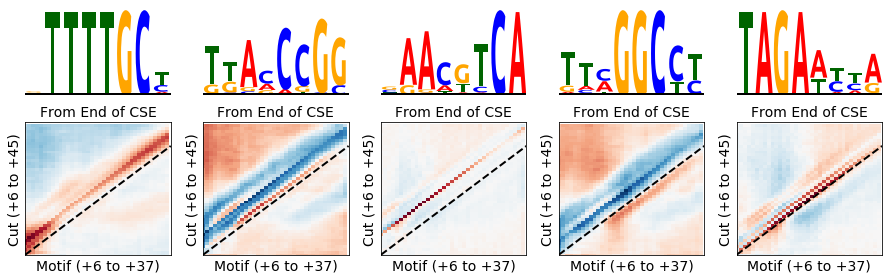

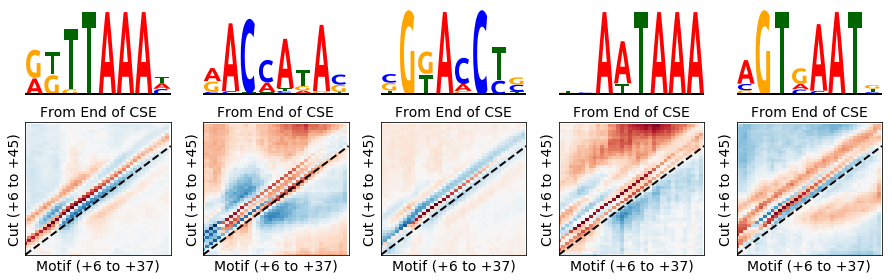

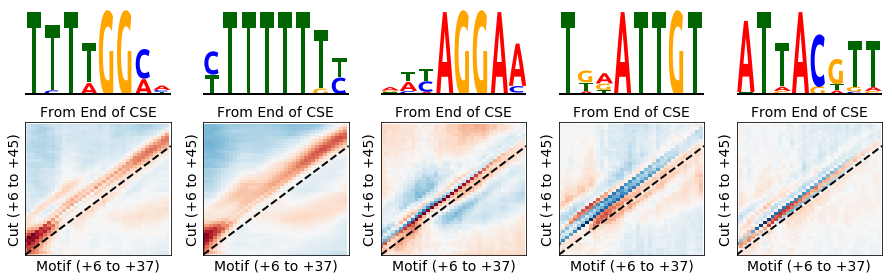

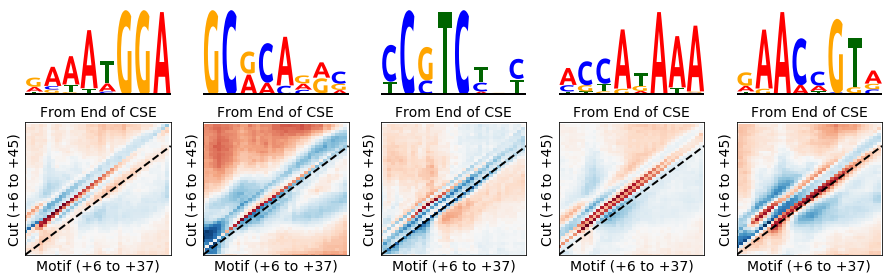

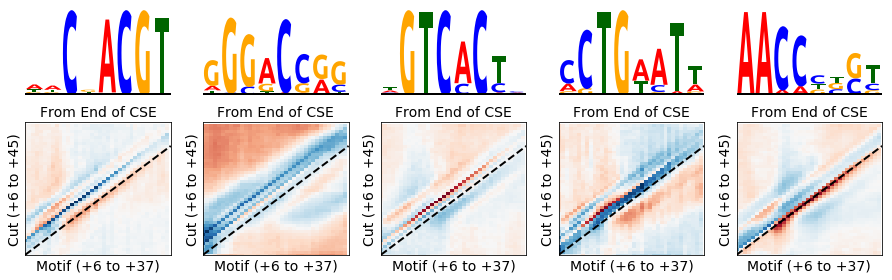

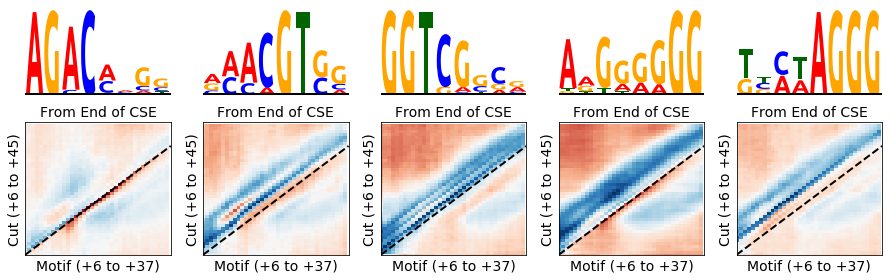

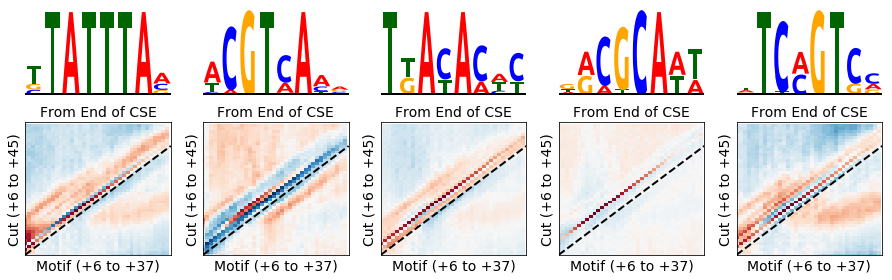

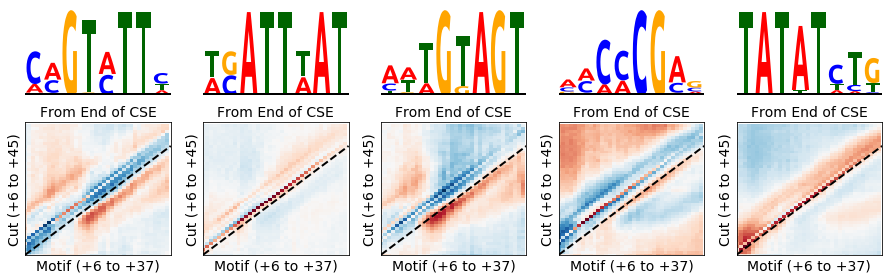

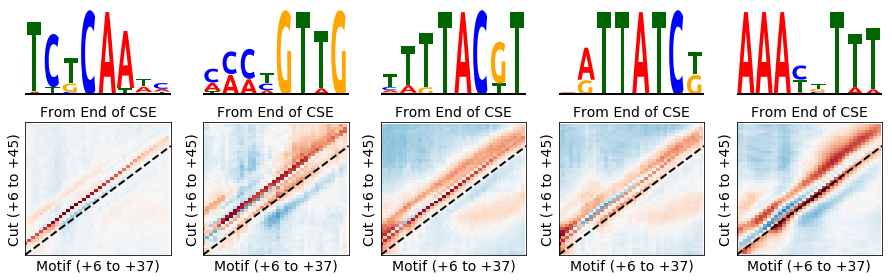

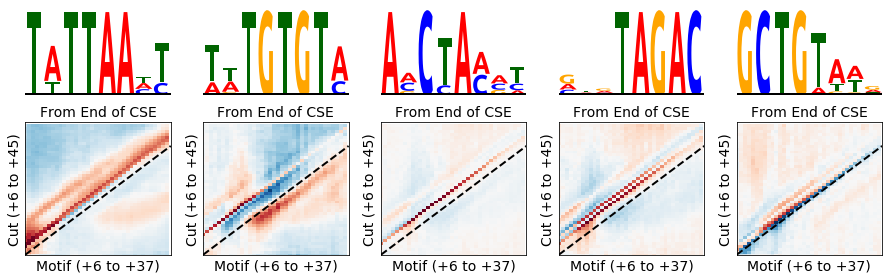

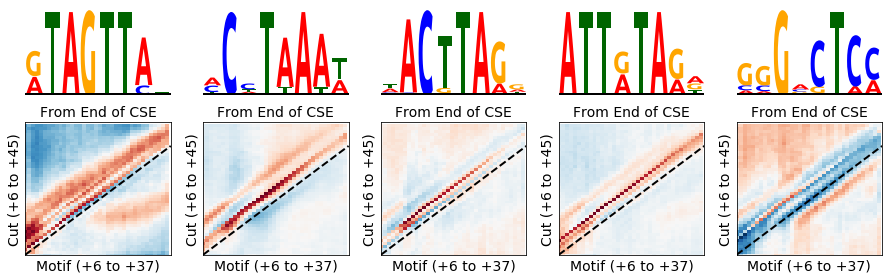

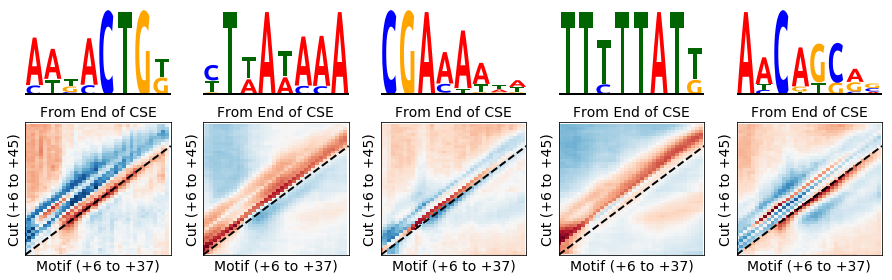

In [16]:
#Plot Max Activation PWMs and Correlation maps

n_filters_per_row = 5

n_rows = int(pwms.shape[0] / n_filters_per_row)
k = 0
for row_i in range(n_rows) :
    
    f, ax = plt.subplots(2, n_filters_per_row, figsize=(2.5 * n_filters_per_row, 4), gridspec_kw = {'height_ratios':[2, 3]})

    for kk in range(n_filters_per_row) :
        plot_pwm_cut_logo(pwms_top, r_vals, k, ax[0, kk], ax[1, kk])
        k += 1

    plt.sca(plt.gca())
    plt.tight_layout()

    plt.show()

